In [1]:
import streamlit as st
import chess
import chess.svg
import langgraph
import cairosvg
import random
import json
from io import BytesIO
from langchain.chat_models import ChatOpenAI
from langchain.schema import SystemMessage, HumanMessage
from langgraph.graph import StateGraph, START, END
from dotenv import load_dotenv
import os

# ✅ 환경 변수 로드
load_dotenv()
openai_api_key = os.getenv("OPENAI_API_KEY")

# ✅ OpenAI LLM 설정
llm = ChatOpenAI(
    model="gpt-4o-mini",
    max_tokens=100,
    temperature=0.5,
    openai_api_key=openai_api_key
)

# ✅ 체스 보드 상태 유지
if "board" not in st.session_state:
    st.session_state.board = chess.Board()
if "chat_history" not in st.session_state:
    st.session_state.chat_history = []
if "next_turn" not in st.session_state:
    st.session_state.next_turn = "white"  # 기본적으로 사용자가 먼저 시작

# ✅ Streamlit 설정
st.set_page_config(page_title="♟️ LLM 체스 챗봇", layout="centered")
st.title("♟️ LLM 체스 챗봇")

# ✅ 체스 보드 렌더링 함수
def render_chessboard(board):
    svg_data = chess.svg.board(board=board, size=400)
    png_data = BytesIO()
    cairosvg.svg2png(bytestring=svg_data.encode('utf-8'), write_to=png_data)
    return png_data

# ✅ UI 업데이트
board_placeholder = st.empty()
board_placeholder.image(render_chessboard(st.session_state.board), caption="현재 체스 보드 상태")

# ✅ "Restart" 버튼 추가 (게임 초기화)
if st.button("🔄 Restart"):
    st.session_state.board = chess.Board()
    st.session_state.chat_history = []
    st.session_state.next_turn = "white"
    board_placeholder.image(render_chessboard(st.session_state.board), caption="새 게임 시작")
    st.rerun()  # 페이지 새로고침

# ✅ 체스 상태(State)를 JSON으로 출력하는 함수 (사용자가 "state" 입력 시 실행)
def get_state():
    state = {
        "fen": st.session_state.board.fen(),
        "next_turn": "white" if st.session_state.board.turn == chess.WHITE else "black",
        "legal_moves": [m.uci() for m in st.session_state.board.legal_moves],
        "is_check": st.session_state.board.is_check(),
        "is_checkmate": st.session_state.board.is_checkmate(),
        "is_stalemate": st.session_state.board.is_stalemate(),
    }
    st.subheader("📌 현재 체스 상태 (State)")
    st.json(state)  # Streamlit UI에 표시
    print(json.dumps(state, indent=4))  # 콘솔 출력
    return state

# ✅ LangGraph 워크플로우 설정
graph = StateGraph(dict)

# 1️⃣ **사용자 입력 노드 (White 기물)**
def user_move(state):
    user_msg = st.chat_input("당신의 움직임을 입력하세요 (예: e2e4, 'state')")

    if user_msg:
        if user_msg.lower() == "state":  # 사용자가 "state"를 입력하면 상태 출력
            get_state()
            return state  # 상태 출력 후 유지

        elif user_msg in [m.uci() for m in st.session_state.board.legal_moves]:
            st.session_state.board.push_uci(user_msg)
            st.session_state.chat_history.append(("🧑‍💻 사용자 (White)", user_msg))
            board_placeholder.image(render_chessboard(st.session_state.board), caption="현재 체스 보드 상태")
            return {"board_state": st.session_state.board, "next_turn": "black"}
        else:
            st.warning("잘못된 움직임입니다. 다시 입력하세요.")
            return state

    return state  # 입력이 없으면 유지

graph.add_node("user_move", user_move)
graph.add_edge(START, "user_move")

# 2️⃣ **AI (Black 기물) 자동 생성 노드**
def ai_move(state):
    messages = [
        SystemMessage(content="You are a chess AI playing as Black. Always respond with a valid move."),
        HumanMessage(content=f"""
### 체스 현재 상태
- FEN: {st.session_state.board.fen()}
- 가능한 수: {', '.join([m.uci() for m in st.session_state.board.legal_moves])}

💡 **다음 수를 UCI 형식으로만 출력하세요! 예: e7e5**
""")
    ]

    retry_count = 0
    while retry_count < 5:
        response = llm(messages).content.strip()
        legal_moves = [m.uci() for m in st.session_state.board.legal_moves]

        if response in legal_moves:
            st.session_state.board.push_uci(response)
            st.session_state.chat_history.append(("🤖 AI (Black)", response))
            board_placeholder.image(render_chessboard(st.session_state.board), caption="현재 체스 보드 상태")
            return {"board_state": st.session_state.board, "next_turn": "white"}  # ✅ 자동 전환 설정
        
        retry_count += 1
        st.warning(f"⚠️ AI가 잘못된 움직임을 생성했습니다. ({response}) 다시 시도 중...")

    # 5번 실패하면 랜덤 선택
    response = random.choice(legal_moves)
    st.warning(f"⚠️ AI가 5회 연속 잘못된 움직임을 생성했습니다. 랜덤 선택: {response}")
    st.session_state.board.push_uci(response)
    st.session_state.chat_history.append(("🤖 AI (Black)", response))
    board_placeholder.image(render_chessboard(st.session_state.board), caption="현재 체스 보드 상태")
    return {"board_state": st.session_state.board, "next_turn": "white"}

graph.add_node("ai_move", ai_move)

# 3️⃣ **게임 상태 업데이트 노드 (AI가 자동으로 실행되도록 수정)**
def check_game_status(state):
    if st.session_state.board.is_checkmate():
        st.error("체크메이트! 게임 종료.")
        return {"game_over": True}
    if st.session_state.board.is_stalemate():
        st.warning("무승부! 게임 종료.")
        return {"game_over": True}
    
    # ✅ 자동 실행을 위해 상태 전이 설정
    if state["next_turn"] == "black":
        return "ai_move"  # AI 차례에서는 자동 실행
    return "user_move"

graph.add_node("check_status", check_game_status)
graph.add_conditional_edges(
    "check_status",
    lambda state: "game_over" if state.get("game_over") else state["next_turn"],
    {
        "black": "ai_move",
        "white": "user_move",
        "game_over": "game_over"
    }
)

# ✅ "game_over" 노드 추가
graph.add_node("game_over", lambda state: state)
graph.add_edge("game_over", END)

# ✅ LangGraph 실행
app = graph.compile()

# ✅ 체스 게임 실행
state = {"board_state": st.session_state.board, "next_turn": st.session_state.next_turn}

# ✅ LangGraph가 AI 턴을 자동으로 실행하도록 설정
state = app.invoke(state)


C:\Users\tree\AppData\Local\Temp\ipykernel_16500\2102826318.py:20: LangChainDeprecationWarning: The class `ChatOpenAI` was deprecated in LangChain 0.0.10 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-openai package and should be used instead. To use it run `pip install -U :class:`~langchain-openai` and import as `from :class:`~langchain_openai import ChatOpenAI``.
  llm = ChatOpenAI(
2025-01-29 15:06:14.093 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-01-29 15:06:14.096 WARNING streamlit.runtime.state.session_state_proxy: Session state does not function when running a script without `streamlit run`
2025-01-29 15:06:14.100 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-01-29 15:06:14.104 WARNI

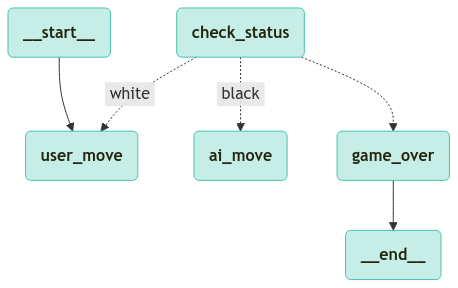

In [2]:
from langchain_teddynote.graphs import visualize_graph

# 그래프 시각화
visualize_graph(app)